In [1]:
import pandas as pd

In [2]:
df_orig = pd.read_csv("./data/Telco_Customer_Churn.csv")

In [3]:
df = df_orig.copy()
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
df[["customerID", "Churn"]].groupby('Churn').count()

customerID
Churn            
No           5174
Yes          1869

In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df = df.drop("customerID", axis=1)

In [7]:
cat_features = df.dtypes[(df.dtypes=="object")].index.tolist()
cat_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

In [109]:
from ydata_profiling import ProfileReport

In [8]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [111]:
pr = ProfileReport(df)
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

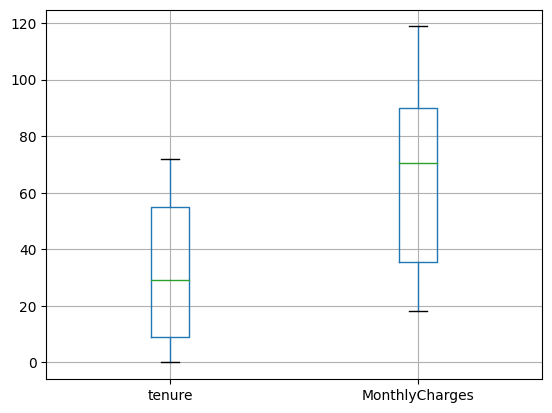

In [9]:
%matplotlib inline

df.boxplot(column=["tenure", "MonthlyCharges"])

In [113]:
import mlflow

## Create the model setup

In [10]:
from pycaret.classification import *

clf = setup(data=df, target="Churn", 
            categorical_features=cat_features[:-1],
            # profile=True,
            log_experiment=True,
            experiment_name='Customer_Churn',
            train_size=0.8,
            normalize=True,
            normalize_method='minmax')

## Create the model

In [34]:
best = compare_models(sort="F1")

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

2023/08/18 17:37:45 INFO mlflow.tracking.fluent: Experiment with name 'Customer_Churn' does not exist. Creating a new experiment.


In [16]:
best

GaussianNB(priors=None, var_smoothing=1e-09)

In [17]:
save_model(best, f"./GNB_Customer_Churn")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\LOGASU~1\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SeniorCitizen', 'tenure',
                                              'MonthlyCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=Tru...
                                                               drop_invariant=False,
                                                               handle_missing='return_nan',
                                                               handle_unknown='value',
                                                               hierarchy=Non

In [117]:
best.get_params()

{'priors': None, 'var_smoothing': 1e-09}

## Optimize the model

In [118]:
t_model, tuner = tune_model(best, n_iter=100, optimize='AUC', return_tuner=True)

Initiated  . . . . . . . . . . . . . . . . . .              14:16:11
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [122]:
tuner.cv

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

Best model "NB" is performing not as expected even after tuning so let's choose 2nd best model and tune it further. 

In [11]:
lbm = create_model("lightgbm", fold=5)

\
                                                 
Initiated  . . . . . . . . . . . . . . . . . .   
Status     . . . . . . . . . . . . . . . . . .   
Estimator  . . . . . . . . . . . . . . . . . .   

                                            
                                            
Initiated                         20:30:54  
Status                 Selecting Estimator  
Estimator  Light Gradient Boosting Machine

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [121]:
t_model, tuner = tune_model(lbm, n_iter=5, optimize='AUC', return_tuner=True)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [124]:
t_model

LGBMClassifier(bagging_fraction=1.0, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=96, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=30, objective=None,
               random_state=2197, reg_alpha=1e-07, reg_lambda=0.1,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Lets try boosting ensemble models

In [125]:
boosted_lbm = ensemble_model(t_model, method = 'Boosting')

Lets try bagging

In [128]:
bagging_lbm = ensemble_model(t_model, method = 'Bagging', n_estimators=100, choose_better=True)

Initiated  . . . . . . . . . . . . . . . . . .              15:39:55
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

In [129]:
evaluate_model(bagging_lbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [28]:
interpret_model(lbm, plot = 'reason')#, feature="PhoneService")

In [12]:
import dash_bootstrap_components as dbc

In [59]:
lbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3404, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [13]:
dashboard_kwargs = {
    "header_hide_download": True,
    "hide_poweredby": True,
    "hide_header": True,
    'bootstrap': dbc.themes.SUPERHERO
}

run_kwargs = {
    "host": '127.0.0.1',
    "use_waitress": True,
}


dashboard(lbm, display_format="external", dashboard_kwargs=dashboard_kwargs)

Note: model_output=='probability'. For LGBMClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr a

Dash app running on http://127.0.0.1:8050/


In [32]:
deep_check(lbm)

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_UOKSPIGB69830DF96OUG6VWFO">Full Suite</h1>\n<…